# Example of Downloading and Plotting the Spectra

Astro 128/256 (UC Berkeley, 2025)

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy import units as u 

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=14)

Spectra and all associated data are stored in .fits files.
- Great alogorithms for compression
- Can hold many different data types
- Contain headers, images, **spectra**, tables, etc.

APOGEE Spectra are all hosted on the data.sdss.org website so we can use Python to directly download spectra from online! Astropy has functionality directly built into the fits module to do it for you. We just have to find the spectra/stars we care about for our problem.

In [12]:
base = 'https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/apo25m/'
field = 'M15'
filename = 'apStar-dr17-2M21235315+1244123.fits'

try:
    url = base+f"{field}/{filename}"
    with fits.open(url) as hdul:
        header = hdul[0].header
        spectra = hdul[1].data
        print('Shape of Spectra', spectra.shape)
        errors = hdul[2].data
        print('Shape of Errors', errors.shape)
        bitmasks = hdul[3].data
        print('Shape of Bitmasks', bitmasks.shape)

except Exception as err:
    print(f"Error downloading {filename}: {err}")

Shape of Spectra (4, 8575)
Shape of Errors (4, 8575)
Shape of Bitmasks (4, 8575)


We have 4 different spectra for this star.
- **Spectra 1: The Co-added Spectra of all the visits**
- Spectra 2: Co-added in a different way
- Spectra 3: Visit 1
- Spectra 4: Visit 2

We now have the fluxes (spectra), errors, and a bitmask for the "bad" pixels, but we need a wavelngth grid! Let's take a look at the header for that.

In [6]:
spectrum = spectra[0]
error = errors[0]
bitmask = bitmasks[0]

header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CRVAL1  =                4.179 / Start log10(wavelength) in subsequent HDUs     
CDELT1  =                6E-06 / Dispersion in log10(wave) in subsequent HDUs   
CRPIX1  =                    1 / Pixel of starting wavelength in subsequent HDUs
CTYPE1  = 'LOG-LINEAR'         / Logarithmic wavelength scale in subsequent HDUs
DC-FLAG =                    1 / Logarithmic wavelength scale in subsequent HDUs
NWAVE   =                 8575 / Number of wavelengths in subsequent HDUs       
FIELD   = 'M15     '           / APOGEE field name                              
OBJID   = '2M21235315+1244123' / APOGEE object name                             
SNR     =       212.04248320

The important entries are CRVAL1, CDELT1, and NWAVE. We can use these 3 values to build the wavelength grid. The grid is 'LOG-LINEAR' as mentioned in entry CTYPE1. So,

$$ \lambda_i = 10^{{\rm CRVAL1}+i\cdot{\rm CDELT1}} $$

In [9]:
wavelength = 10.0 ** np.arange(header['CRVAL1'], header['CRVAL1']+header['NWAVE']*header['CDELT1'], header['CDELT1']) * u.angstrom

Now we can plot our spectra!

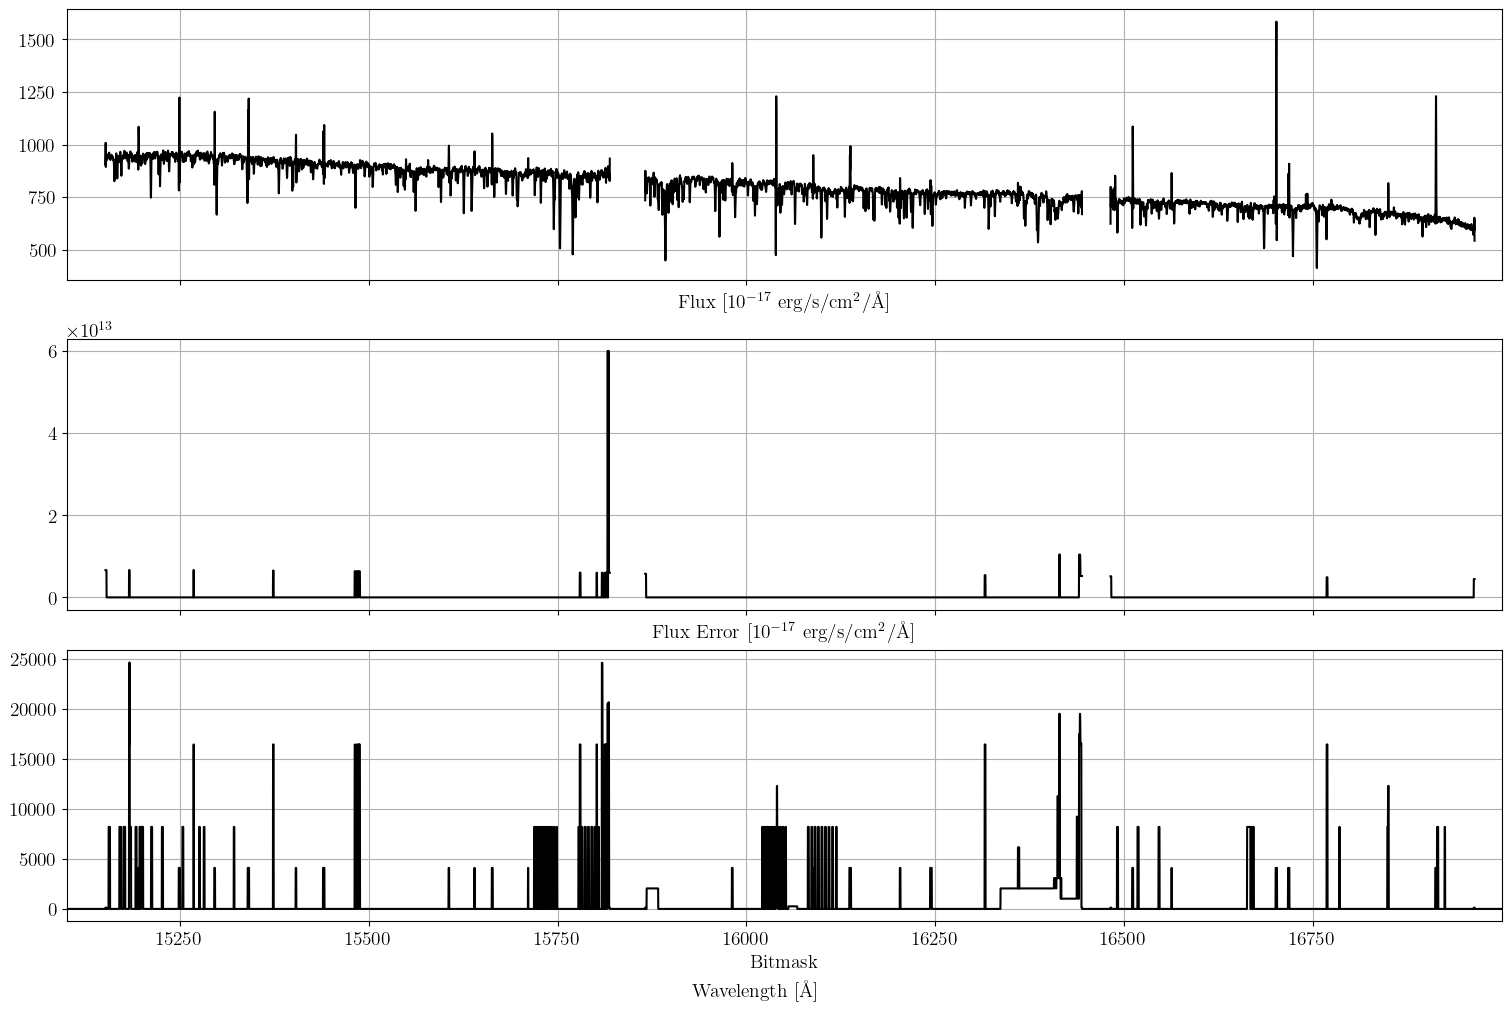

In [15]:
fig, axes = plt.subplots(3, 1, sharex=True, layout='constrained', figsize=(15, 10))
xlabels = ('Flux [$10^{-17}$ erg/s/cm$^2$/\AA]', 'Flux Error [$10^{-17}$ erg/s/cm$^2$/\AA]', 'Bitmask')

for ax, data, xlabel in zip(axes, (spectrum, error, bitmask), xlabels):
    ax.plot(wavelength, data, c='k')
    ax.set_xlim(wavelength.min().value, wavelength.max().value)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.grid(True)
fig.supxlabel('Wavelength [\AA]', fontsize=14)
plt.show()

What is going on with the bitmask? That does not look like a boolean mask! Bitmasks are a somewhat outdated, but widely used way to have multiple boolean flags all stored in 1 number. The bitmask only seems to take on certain integer values. Any integer can be represented in base 2 also known as binary. For example, 9 is 1001 becausee 9 = 8x1 + 4x0 + 2x0 + 1x1. Each of these bits represent a different flag. If we take a look at the website the 0th bit and the 3rd bit being set means that "Pixel marked as BAD in bad pixel mask or from strong persistence jump" and "Pixel marked as unfixable in ap3d". **In this lab we only care if bits 0-7 and 12 are marked.**

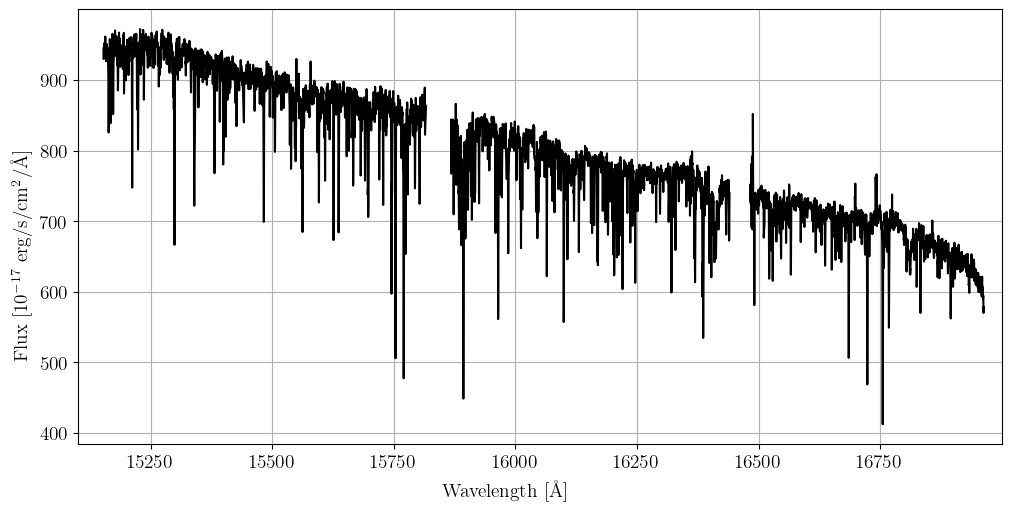

In [19]:
target_bits = [0,1,2,3,4,5,6,7,12] # the bits we care about
target_number = np.sum(2**np.array(target_bits)) # turning our target bits into an integer
boolean_mask = np.zeros_like(bitmask, dtype=bool) # initializing an empty boolean mask
boolean_mask[(bitmask & target_number) != 0] = True # doing a bitwise AND with the bitmask from the spectra and our target integer

fig, ax = plt.subplots(1, 1, sharex=True, layout='constrained', figsize=(10, 5))
ax.plot(wavelength[~boolean_mask], spectrum[~boolean_mask], c='k')
ax.set_xlim(wavelength.min().value, wavelength.max().value)
ax.grid(True)
fig.supxlabel('Wavelength [\AA]', fontsize=14)
fig.supylabel('Flux [$10^{-17}$ erg/s/cm$^2$/\AA]', fontsize=14)
plt.show()